In [1]:
import scanpy as sc
import torch
import lightning.pytorch as pl
from torch import nn
from torch.optim import AdamW
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

# 1. 加载数据集
data_dir = '../../dataset/Xenium_breast_cancer_sample1_replicate1.h5ad'
adata = sc.read_h5ad(data_dir)

# 数据预处理
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# 2. 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 没有实际数据路径，可以设置为None

# 3. 直接初始化从头训练的模型
estim.model = MLPAutoEncoder(
    gene_dim=19331,  # 根据你的数据调整
    batch_size=128,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [2]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)

# 处理基因数据
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
all_genes = var_df['feature_name'].tolist()

new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)
adata.var['gene_name'] = adata.var.index
existing_genes = adata.var['gene_name']

# 将基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 计算基因匹配
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)
matching_genes = all_genes_set.intersection(adata_genes_set)

# 填充 new_data
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)

# 4. 数据集划分（70% 训练，15% 验证，15% 测试）
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])

random_seed = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

# 5. 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(estim.model.parameters(), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

# 使用 TensorDataset 将训练数据和标签打包
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Gene fam49a not found in all_genes list
Gene kars not found in all_genes list
Gene lars not found in all_genes list


Gene nars not found in all_genes list
Gene polr2j3 not found in all_genes list
Gene qars not found in all_genes list


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Gene trac not found in all_genes list
Gene wars not found in all_genes list


In [3]:
# 6. 定义训练过程
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)



In [4]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")

Epoch 1, Train Loss: 0.4296158143280638, Validation Loss: 0.3282613104521321
Validation loss improved to 0.3282613104521321, resetting patience.


Epoch 2, Train Loss: 0.3040316050835684, Validation Loss: 0.2659482281976545
Validation loss improved to 0.2659482281976545, resetting patience.


Epoch 3, Train Loss: 0.27970092443339445, Validation Loss: 0.2673995686590974
No improvement in validation loss. Patience counter: 1/20


Epoch 4, Train Loss: 0.2670926025993554, Validation Loss: 0.2755431799870457
No improvement in validation loss. Patience counter: 2/20


Epoch 5, Train Loss: 0.25759886347228145, Validation Loss: 0.24278766317718525
Validation loss improved to 0.24278766317718525, resetting patience.


Epoch 6, Train Loss: 0.246328729405707, Validation Loss: 0.2590189416169515
No improvement in validation loss. Patience counter: 1/20


Epoch 7, Train Loss: 0.24110056985015443, Validation Loss: 0.25025339715825723
No improvement in validation loss. Patience counter: 2/20


Epoch 8, Train Loss: 0.23330037652115157, Validation Loss: 0.23492032694181209
Validation loss improved to 0.23492032694181209, resetting patience.


Epoch 9, Train Loss: 0.22681314436503744, Validation Loss: 0.241216385462865
No improvement in validation loss. Patience counter: 1/20


Epoch 10, Train Loss: 0.21994378360917624, Validation Loss: 0.24023307300158564
No improvement in validation loss. Patience counter: 2/20


Epoch 11, Train Loss: 0.21419371574435359, Validation Loss: 0.24148995886901914
No improvement in validation loss. Patience counter: 3/20


Epoch 12, Train Loss: 0.20883592080998525, Validation Loss: 0.25133275887385237
No improvement in validation loss. Patience counter: 4/20


Epoch 13, Train Loss: 0.20203665114760658, Validation Loss: 0.2531571786869601
No improvement in validation loss. Patience counter: 5/20


Epoch 14, Train Loss: 0.19655202724412896, Validation Loss: 0.2387808453915688
No improvement in validation loss. Patience counter: 6/20


Epoch 15, Train Loss: 0.1941723475366636, Validation Loss: 0.22906328174214677
Validation loss improved to 0.22906328174214677, resetting patience.


Epoch 16, Train Loss: 0.18916914084914074, Validation Loss: 0.22162590274199617
Validation loss improved to 0.22162590274199617, resetting patience.


Epoch 17, Train Loss: 0.18276568185659794, Validation Loss: 0.2381163388490677
No improvement in validation loss. Patience counter: 1/20


Epoch 18, Train Loss: 0.1800501576395531, Validation Loss: 0.21929263244123023
Validation loss improved to 0.21929263244123023, resetting patience.


Epoch 19, Train Loss: 0.175319572310075, Validation Loss: 0.24888936751687588
No improvement in validation loss. Patience counter: 1/20


Epoch 20, Train Loss: 0.17172079644123323, Validation Loss: 0.2665754076339267
No improvement in validation loss. Patience counter: 2/20


Epoch 21, Train Loss: 0.1694647049153942, Validation Loss: 0.2367027923086573
No improvement in validation loss. Patience counter: 3/20


Epoch 22, Train Loss: 0.16141651777757537, Validation Loss: 0.23034426267377012
No improvement in validation loss. Patience counter: 4/20


Epoch 23, Train Loss: 0.16414255129826744, Validation Loss: 0.2331240213461939
No improvement in validation loss. Patience counter: 5/20


Epoch 24, Train Loss: 0.1610518503439063, Validation Loss: 0.24091204796648266
No improvement in validation loss. Patience counter: 6/20


Epoch 25, Train Loss: 0.15598411223808534, Validation Loss: 0.23687239842215166
No improvement in validation loss. Patience counter: 7/20


Epoch 26, Train Loss: 0.1542232764036697, Validation Loss: 0.2555827664088477
No improvement in validation loss. Patience counter: 8/20


Epoch 27, Train Loss: 0.14955737876395384, Validation Loss: 0.244281261327303
No improvement in validation loss. Patience counter: 9/20


Epoch 28, Train Loss: 0.14858092355474928, Validation Loss: 0.24659225321965775
No improvement in validation loss. Patience counter: 10/20


Epoch 29, Train Loss: 0.14535396503921688, Validation Loss: 0.23300617267637688
No improvement in validation loss. Patience counter: 11/20


Epoch 30, Train Loss: 0.14008746735654234, Validation Loss: 0.24617454727289034
No improvement in validation loss. Patience counter: 12/20


Epoch 31, Train Loss: 0.13575685406124022, Validation Loss: 0.2629842374303619
No improvement in validation loss. Patience counter: 13/20


Epoch 32, Train Loss: 0.13528645350668814, Validation Loss: 0.25930457061090445
No improvement in validation loss. Patience counter: 14/20


Epoch 33, Train Loss: 0.13432742966935526, Validation Loss: 0.26687622785114395
No improvement in validation loss. Patience counter: 15/20


Epoch 34, Train Loss: 0.131686051459354, Validation Loss: 0.24390006995745722
No improvement in validation loss. Patience counter: 16/20


Epoch 35, Train Loss: 0.129181766657317, Validation Loss: 0.2491309113308863
No improvement in validation loss. Patience counter: 17/20


Epoch 36, Train Loss: 0.12776208509262935, Validation Loss: 0.2511958592963703
No improvement in validation loss. Patience counter: 18/20


Epoch 37, Train Loss: 0.12701309984042625, Validation Loss: 0.24817302115828857
No improvement in validation loss. Patience counter: 19/20


Epoch 38, Train Loss: 0.12296157025109189, Validation Loss: 0.26303129820956794
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 38.
Loaded best model weights based on validation loss.


In [5]:
import os

# 定义保存路径
save_dir = './xenium_best_model_ckpt'
save_path = os.path.join(save_dir, f'supervised_Xenium_breast_cancer_sample1_replicate1_best_model_{random_seed}.ckpt')

# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(best_model_weights, save_path)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


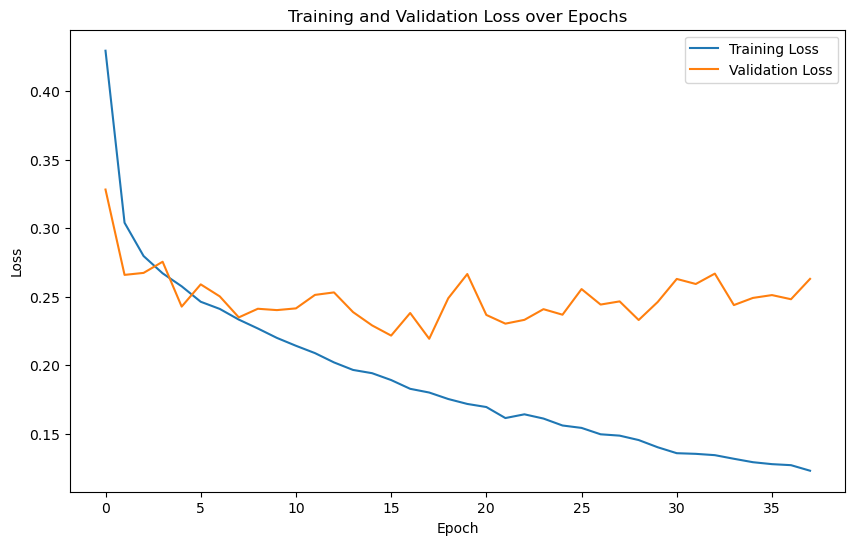

In [6]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig(f'../loss_curve_fig/xenium_breast_cancer_supervised_finetune_full_loss_curve{random_seed}.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig(f'../loss_curve_fig/xenium_breast_cancer_supervised_finetune_full_loss_curve{random_seed}.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()

In [ ]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)

predictions = knn.predict(test_embeddings)

accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")

macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.9261334286963087
Weighted F1 Score: 0.925150790375417
Macro F1 Score: 0.8613811886402386
Random Guess Accuracy: 0.1320247177116093
                         precision    recall  f1-score   support

                B_Cells       0.92      0.95      0.94       772
           CD4+_T_Cells       0.85      0.88      0.86      1286
           CD8+_T_Cells       0.85      0.82      0.84      1026
                 DCIS_1       0.94      0.97      0.95      1937
                 DCIS_2       0.92      0.92      0.92      1746
            Endothelial       0.94      0.97      0.96      1348
              IRF7+_DCs       0.92      0.95      0.93        74
         Invasive_Tumor       0.96      0.97      0.96      5230
             LAMP3+_DCs       0.90      0.94      0.92        49
          Macrophages_1       0.91      0.94      0.93      1692
          Macrophages_2       0.85      0.91      0.88       223
             Mast_Cells       0.86      0.68      0.76     

In [8]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'supervised_{random_seed}'] = SSL_embeddings
new_adata.uns[f'supervised_y_test_{random_seed}'] = y_test
new_adata.uns[f'supervised_predictions_{random_seed}'] = predictions
new_adata.uns[f'supervised_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'supervised_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'supervised_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [9]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "Xenium_breast_cancer_sample1_replicate1_supervised_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicor_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['xenium_breast_cancer_sample1_replicate1'],
    'method': [re.search(r'replicate1_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micor_f1
0.430	0.328	18	0.219	0.861	0.925	0.926
